In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from IPython.display import Image
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, average_precision_score

In [8]:
train = pd.read_excel('lendingclub_traindata.xlsx')
validation=pd.read_excel('lendingclub_valdata.xlsx')
test=pd.read_excel('lendingclub_testdata.xlsx')
# 1 = good, 0 = default
print(train.head())
print("----------------------")
print(validation.head())
print("----------------------")
print(test.head())

   home_ownership    income    dti  fico  int_rate  total_acc  loan_status
0               1   44304.0  18.47   690     17.93         20            0
1               0   50000.0  29.62   735     11.99         44            1
2               0   64400.0  16.68   675     13.67         20            1
3               0   38500.0  33.73   660     30.74         17            0
4               1  118000.0  26.66   665     12.79         47            1
----------------------
   home_ownership    income    dti  fico  int_rate  total_acc  loan_status
0               0   25000.0  27.60   660     17.27         20            0
1               0   50000.0  21.51   715      8.90         23            1
2               1  100000.0   8.14   770      7.90         19            1
3               0   75000.0   1.76   685     17.57         13            0
4               1   78000.0  16.11   680      6.89         33            1
----------------------
   home_ownership    income    dti  fico  int_rate  to

In [14]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status',axis=1)
X_val=validation.drop('loan_status',axis=1)
X_test=test.drop('loan_status',axis=1)

# store target column
y_train = train['loan_status']
y_val=validation['loan_status']
y_test=test['loan_status']


print(X_train.shape, y_train.shape, X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(7000, 6) (7000,) (3000, 6) (3000,) (2290, 6) (2290,)


In [23]:
X_train.columns

Index(['home_ownership', 'income', 'dti', 'fico', 'int_rate', 'total_acc'], dtype='object')

In [16]:
X_val.columns

Index(['home_ownership', 'income', 'dti', 'fico', 'int_rate', 'total_acc'], dtype='object')

In [22]:
X_test.columns

Index(['home_ownership', 'income', 'dti', 'fico', 'int_rate', 'total_acc'], dtype='object')

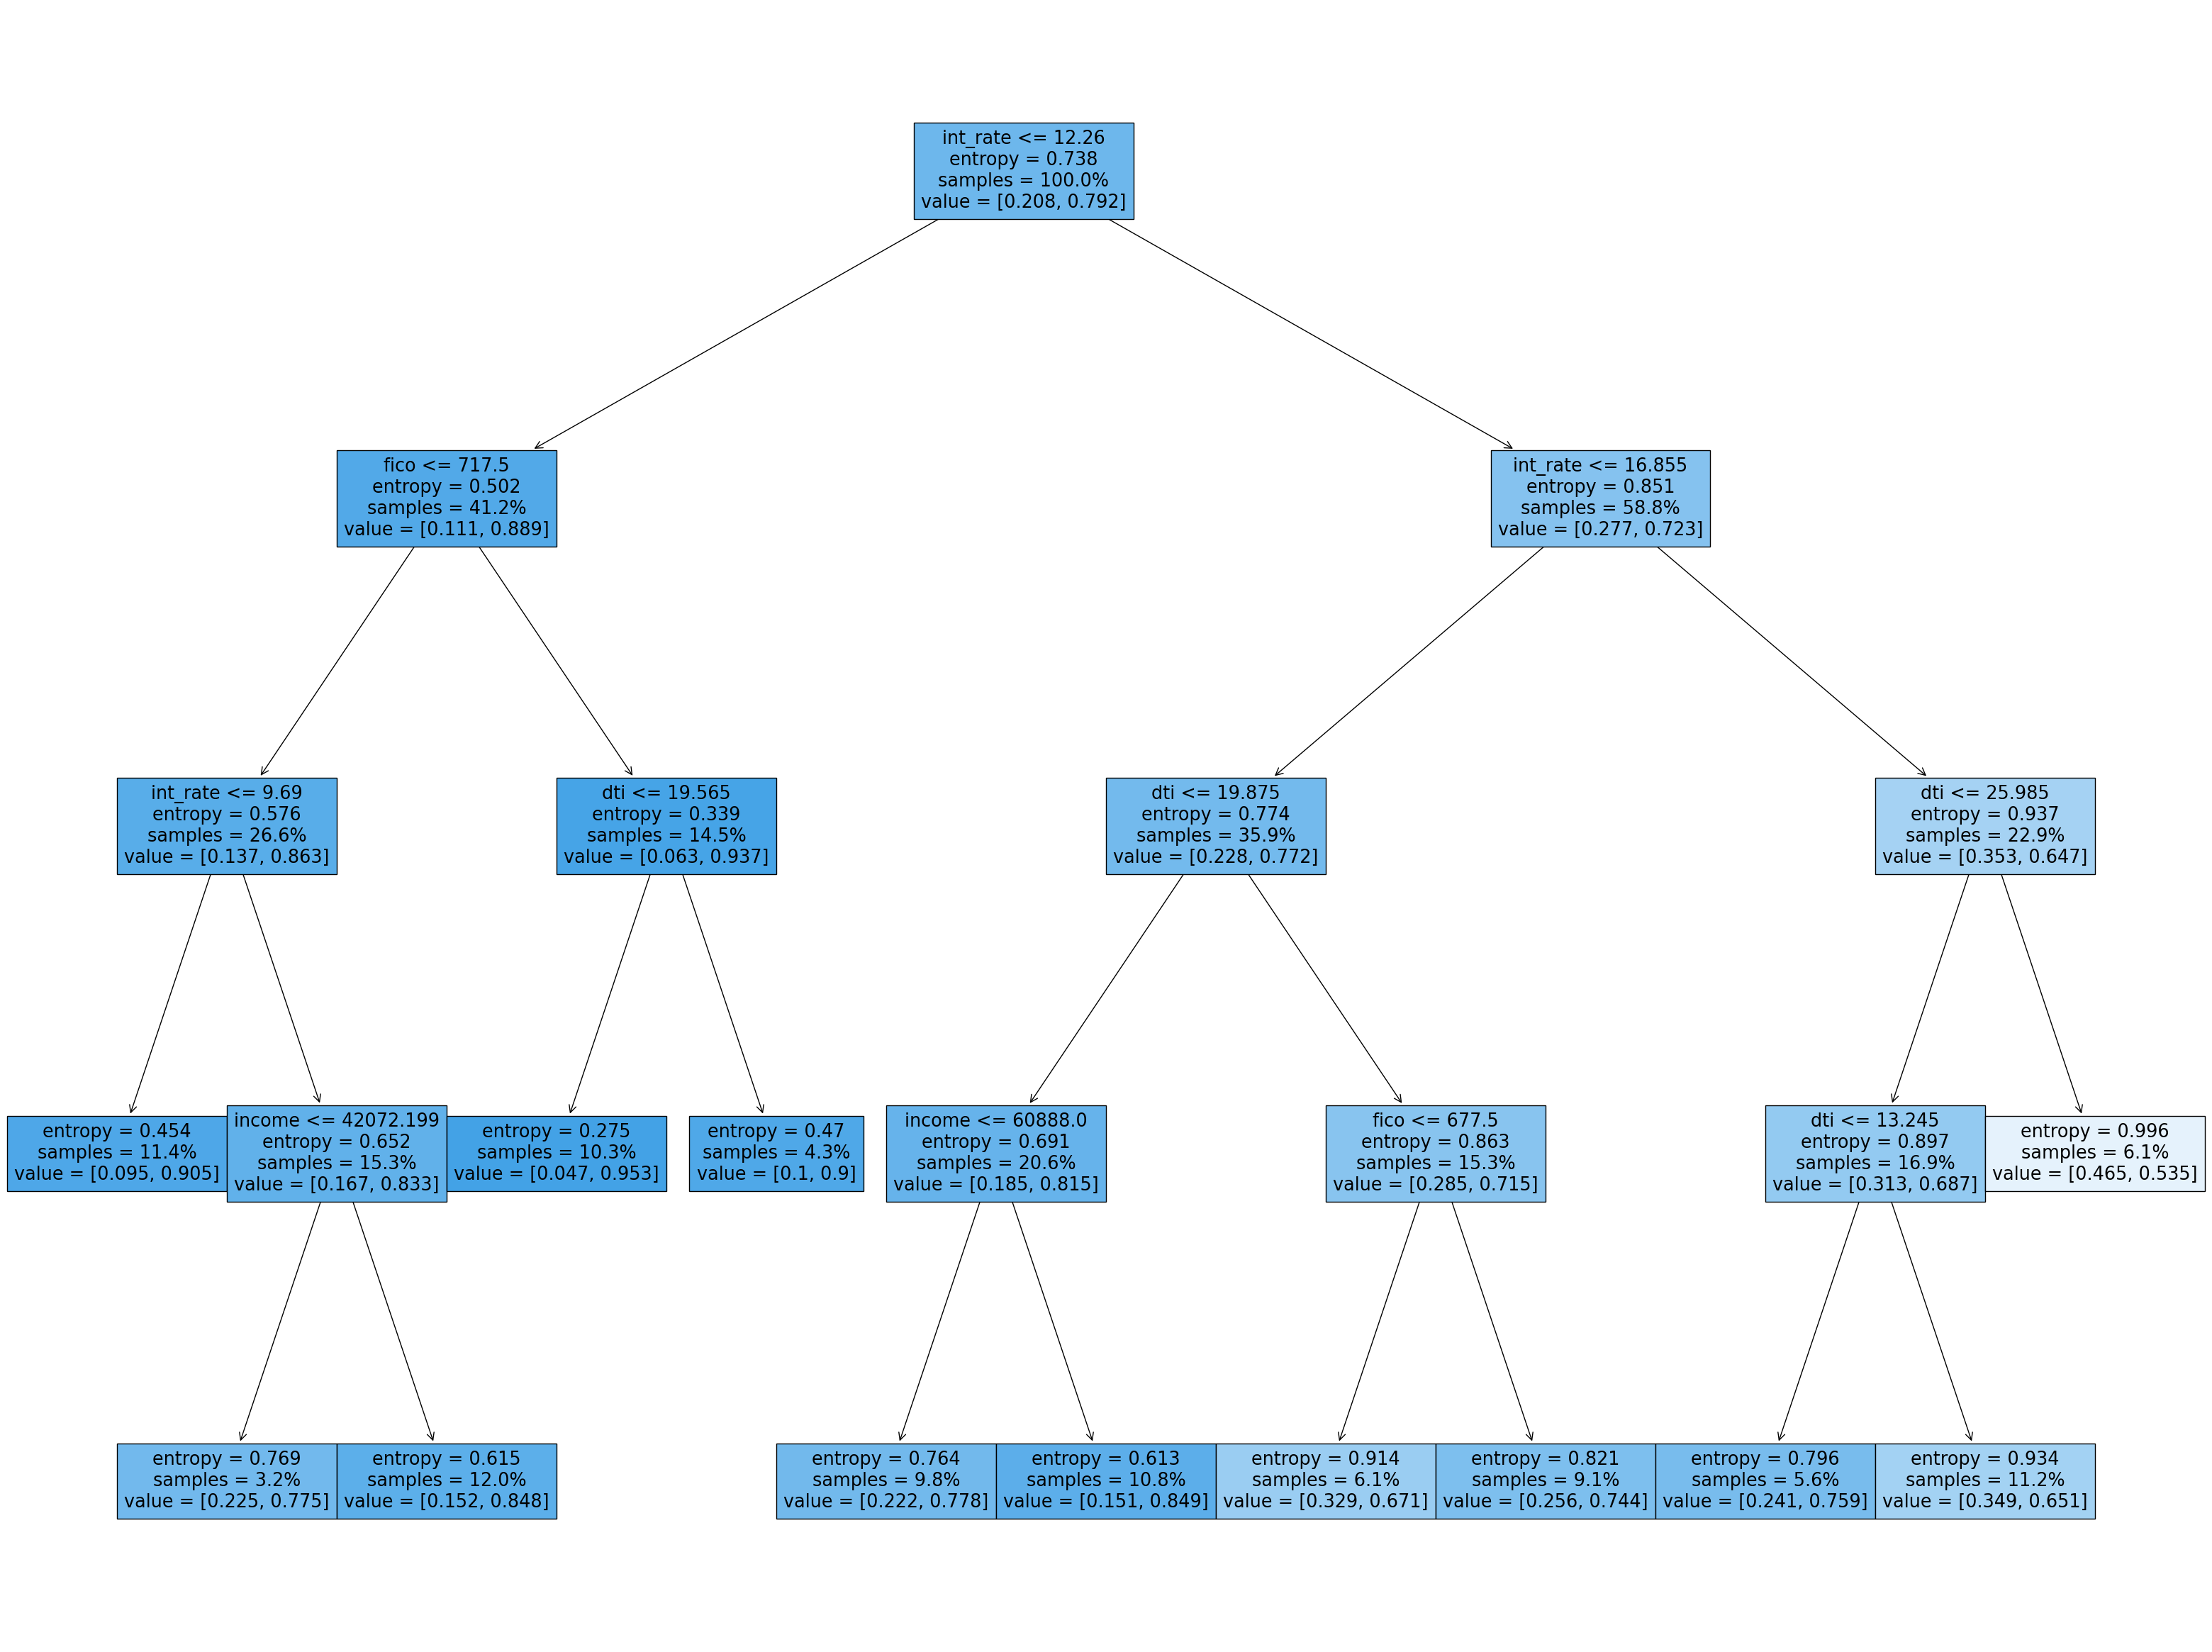

In [17]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_split=1000,min_samples_leaf=200,random_state=0)
clf = clf.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(40, 30))
plot_tree(clf, filled=True, feature_names=X_train.columns, proportion=True)
plt.show()

In [18]:

y_train_pred = clf.predict_proba(X_train)
y_val_pred=clf.predict_proba(X_val)
y_test_pred=clf.predict_proba(X_test)

print (y_train_pred)

# Calculate maximum likelihood for training set, validation set, and test set

mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

# Calculate cost functions from maximum likelihoods

cost_function_training=np.negative(np.sum(mle_vector_train)/len(y_train))
cost_function_val=np.negative(np.sum(mle_vector_val)/len(y_val))
cost_function_test=np.negative(np.sum(mle_vector_test)/len(y_test))

print (y_train_pred)


print('cost function training set =', cost_function_training)
print('cost function validation set =', cost_function_val)
print('cost function test set =', cost_function_test)

[[0.34942821 0.65057179]
 [0.10033445 0.89966555]
 [0.15119363 0.84880637]
 ...
 [0.15119363 0.84880637]
 [0.46462264 0.53537736]
 [0.09547739 0.90452261]]
[[0.34942821 0.65057179]
 [0.10033445 0.89966555]
 [0.15119363 0.84880637]
 ...
 [0.15119363 0.84880637]
 [0.46462264 0.53537736]
 [0.09547739 0.90452261]]
cost function training set = 0.4722642002309908
cost function validation set = 0.47411162199419793
cost function test set = 0.47326732901502067


In [19]:
THRESHOLD = [.75, .80, .85]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
n_test = len(y_test)
Q = clf.predict_proba(X_test)[:,1]

j = 0
for i in THRESHOLD:                                                                                        # iterate over each threshold
                                                                         # fit data to model
    preds = np.where(Q>i, 1, 0)                                       # if prob > threshold, predict 1

    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100
    # confusion matrix (in percentage)

    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')

    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives

    results.iloc[j,1] = accuracy_score(y_test, preds)
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)

    j += 1

print('ALL METRICS')
print(results.T.to_string(header=False))

Confusion matrix for threshold = 0.75
[[58.07860262 21.09170306]
 [10.08733624 10.74235808]]
 
Confusion matrix for threshold = 0.8
[[44.01746725 35.15283843]
 [ 6.11353712 14.71615721]]
 
Confusion matrix for threshold = 0.85
[[24.14847162 55.02183406]
 [ 2.18340611 18.64628821]]
 
ALL METRICS
THRESHOLD           0.75       0.8      0.85
accuracy         0.68821  0.587336  0.427948
true pos rate   0.733591  0.555985  0.305019
true neg rate   0.515723  0.706499  0.895178
false pos rate  0.484277  0.293501  0.104822
precision       0.852018  0.878049  0.917081
f-score         0.788382  0.680851  0.457781


In [20]:
# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)

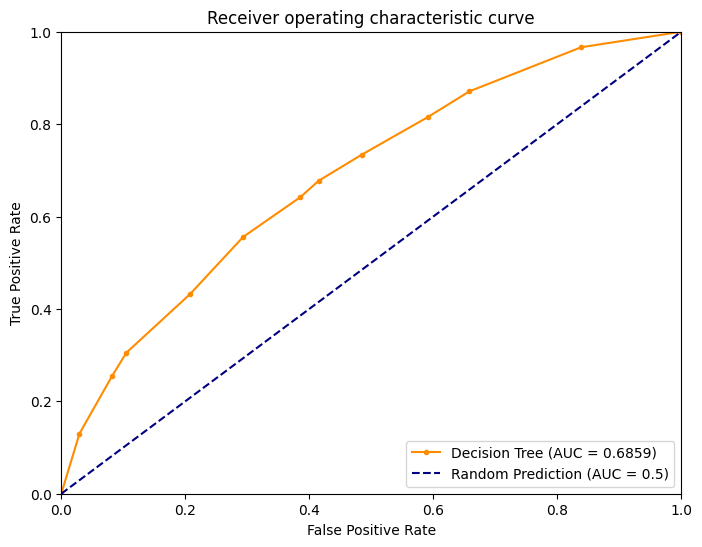

In [21]:
plt.figure(figsize=(8,6))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange', marker='.',
         lw=lw, label='Decision Tree (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Prediction (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()